In [1]:
import torch
from models import MotionTransformer
from utils.get_opt import get_opt
import numpy as np
from os.path import join as pjoin
from trainers import DDPMTrainer

encoder = MotionTransformer(
        input_feats=264,
        num_frames=360,
        num_layers=8,
        latent_dim=512,
        no_clip=False,
        no_eff=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
opt_path = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/beat/test/opt.txt"
opt = get_opt(opt_path, device)
opt.do_denoise = True

mean = np.load(pjoin(opt.meta_dir, 'mean.npy'))
std = np.load(pjoin(opt.meta_dir, 'std.npy'))
trainer = DDPMTrainer(opt, encoder)
# trainer.load(pjoin(opt.model_dir, opt.which_epoch + '.tar'))
trainer.load("/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/latest.tar")

trainer.eval_mode()
trainer.to(opt.device)

result_dict = {}
with torch.no_grad():
        caption = ["it's a fantastic film it captured many young people's hearts with it's amazing music and sentimental plots when i think of the movie titanic the word that comes to my mind mind to mises the whole film would be love it's a kind of thing that makes you makes the world go round watching these kinds of romantic movies is just like reading a book that teaches me how to love and be loved moreover we can learn we can learn more from it such things as loyalty and what we treasure in our lives another movie about love is the secret the movie secret is about a story of a musical prodigy do that falls in love with a girl who's dying"]
        m_lens = torch.LongTensor([60]).to(device)
        pred_motions = trainer.generate(caption, m_lens, 264)
        motion = pred_motions[0].cpu().numpy()
        print(motion.shape)
opt.result_dir = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/beat/test"
np.save(pjoin(opt.result_dir, 'motion.npy'), motion)

/srv/conda/envs/serverai/motion_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Reading /home/serverai/ltdoanh/Motion_Diffusion/checkpoints/beat/test/opt.txt


/srv/conda/envs/serverai/motion_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [00:25<00:00, 38.87it/s]

(60, 264)


✅ Imports successful!

🔨 Creating pipeline from scratch...
   Fitting on BVH sample: 2_scott_0_55_55.bvh
   ✅ Pipeline fitted (structure learned)

📥 Loading Mean/Std from Meta files...
   ✅ Đã tìm thấy Mean và Std từ file .npy
   Shape của Mean: (264,)
   Shape của Std: (264,)
   Mean (5 giá trị đầu): [ 0.00039642  0.02177841 -0.01210624 -0.00077044  0.03148499]

🔧 Overriding pipeline statistics with meta values...
   ✅ Pipeline updated with meta statistics!

🎬 Visualizing: motion.npy
   Motion shape: (60, 264)
   Performing inverse transform...
positions 2 eulers is not supported
   ✅ Reconstructed shape: (60, 264)

   Creating 2D visualization...


<Figure size 1000x800 with 0 Axes>

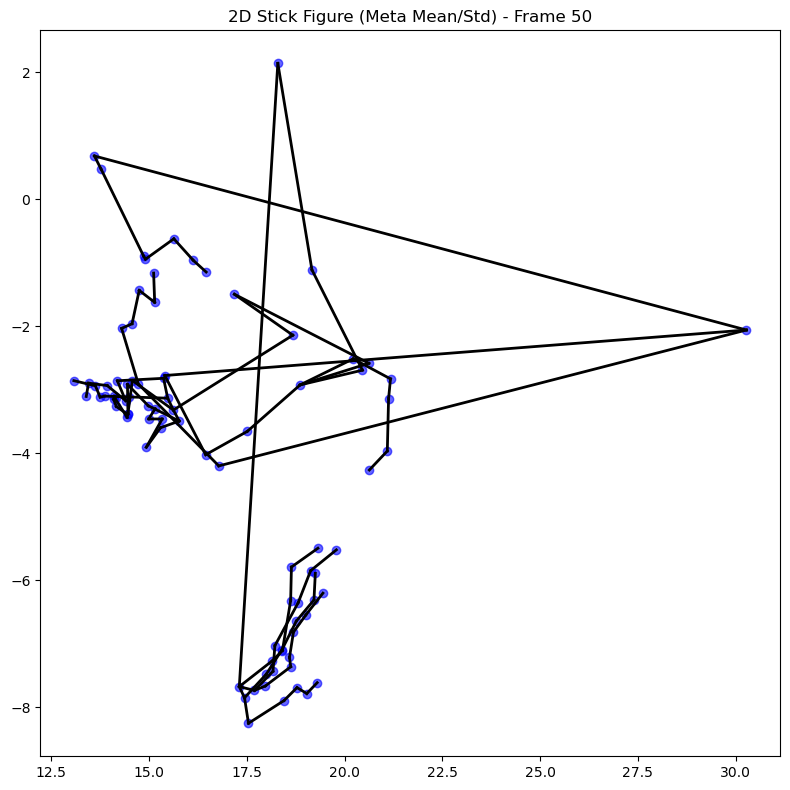


   Creating 3D visualization...


<Figure size 1000x800 with 0 Axes>

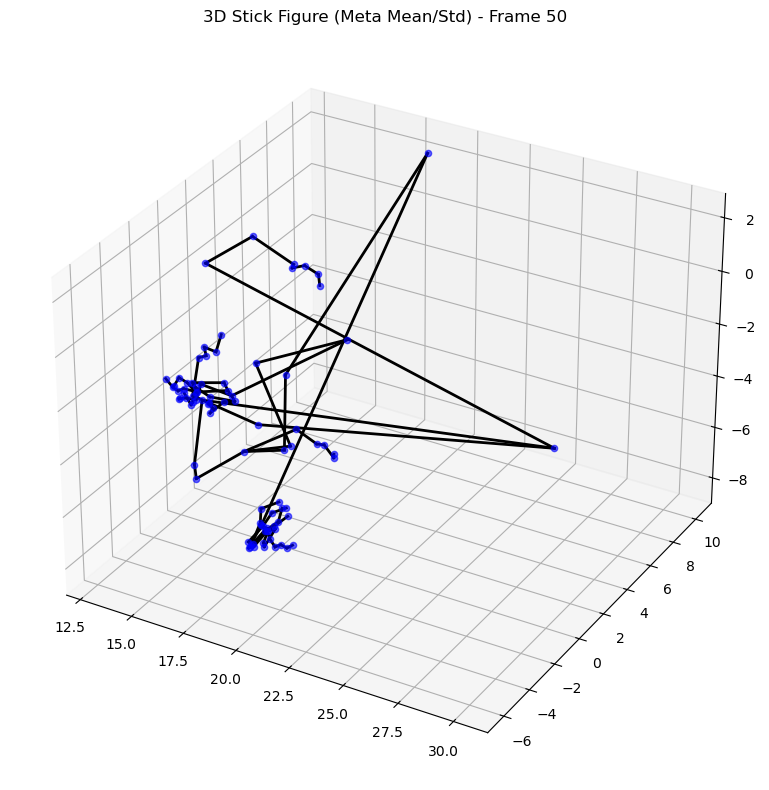

   ✅ Done!


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
import os
import numpy as np
import joblib
import torch

# Setup path
PYOM_DIR = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/pymo"
if PYOM_DIR not in sys.path:
    sys.path.insert(0, PYOM_DIR)

from pymo.parsers import BVHParser
from pymo.preprocessing import *
from pymo.viz_tools import draw_stickfigure, draw_stickfigure3d
from sklearn.pipeline import Pipeline

print("✅ Imports successful!")

# ===== 1. CREATE PIPELINE WITH META =====
print("\n🔨 Creating pipeline from scratch...")

pipeline = Pipeline([
    ('param', MocapParameterizer('position')),
    ('rcpn', RootCentricPositionNormalizer()),
    ('delta', RootTransformer('abdolute_translation_deltas')),
    ('const', ConstantsRemover()),
    ('np', Numpyfier()),
    ('down', DownSampler(2)),
    ('stdscale', ListStandardScaler())
])

# ===== 2. FIT PIPELINE (Structure Learning) =====
# Cần fit vào một file BVH mẫu để pipeline học được cấu trúc xương (skeleton)
bvh_sample_path = "/home/serverai/ltdoanh/Motion_Diffusion/datasets/2_scott_0_55_55.bvh"
print(f"   Fitting on BVH sample: {os.path.basename(bvh_sample_path)}")

if os.path.exists(bvh_sample_path):
    parser = BVHParser()
    parsed_data = parser.parse(bvh_sample_path)
    pipeline.fit([parsed_data])
    print("   ✅ Pipeline fitted (structure learned)")
else:
    print(f"❌ Error: BVH file not found at {bvh_sample_path}")
    sys.exit(1)

# ===== 3. LOAD MEAN/STD FROM META (.npy files) =====
meta_dir = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/beat/test/meta"
mean_path = os.path.join(meta_dir, "mean.npy")
std_path = os.path.join(meta_dir, "std.npy")

print("\n📥 Loading Mean/Std from Meta files...")
try:
    # Load trực tiếp từ file .npy
    mean = np.load(mean_path)
    std = np.load(std_path)

    print("   ✅ Đã tìm thấy Mean và Std từ file .npy")
    print(f"   Shape của Mean: {mean.shape}")
    print(f"   Shape của Std: {std.shape}")
    
    # In thử vài giá trị đầu để kiểm tra
    print(f"   Mean (5 giá trị đầu): {mean[:5]}")
    
    # Override pipeline statistics
    print("\n🔧 Overriding pipeline statistics with meta values...")
    pipeline.named_steps['stdscale'].data_mean_ = mean
    pipeline.named_steps['stdscale'].data_std_ = std
    print("   ✅ Pipeline updated with meta statistics!")

except Exception as e:
    print(f"❌ Có lỗi xảy ra khi load meta: {e}")
    # Nếu không có mean/std thì visualization sẽ bị sai, nên dừng hoặc cảnh báo
    sys.exit(1)

# ===== 4. VISUALIZE MOTION =====
npy_path = "/home/serverai/ltdoanh/Motion_Diffusion/checkpoints/beat/test/motion.npy"
frame = 50

print(f"\n🎬 Visualizing: {os.path.basename(npy_path)}")

if os.path.exists(npy_path):
    # Load motion data
    motion_data = np.load(npy_path)
    print(f"   Motion shape: {motion_data.shape}")

    # Inverse transform
    print("   Performing inverse transform...")
    # Lưu ý: inverse_transform trả về list các object MocapData
    reconstructed = pipeline.inverse_transform([motion_data])
    print(f"   ✅ Reconstructed shape: {reconstructed[0].values.shape}")

    # Visualize 2D
    print("\n   Creating 2D visualization...")
    fig1 = plt.figure(figsize=(10, 8))
    draw_stickfigure(reconstructed[0], frame=frame)
    plt.title(f"2D Stick Figure (Meta Mean/Std) - Frame {frame}")
    plt.tight_layout()
    plt.show()

    # Visualize 3D
    print("\n   Creating 3D visualization...")
    fig2 = plt.figure(figsize=(10, 8))
    draw_stickfigure3d(reconstructed[0], frame=frame)
    plt.title(f"3D Stick Figure (Meta Mean/Std) - Frame {frame}")
    plt.tight_layout()
    plt.show()
    
    print("   ✅ Done!")
else:
    print(f"❌ Error: Motion file not found at {npy_path}")